In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import torch
import pickle
import math
import prior.CustomDistribution as custom
import config

from forward import Forward 
from survey import Survey
from util import *

# SimPEG imports
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh

# SBI imports
from sbi.inference import SNPE, SNLE, prepare_for_sbi, simulate_for_sbi, likelihood_estimator_based_potential, MCMCPosterior
from sbi import utils as utils
from sbi.utils import RestrictionEstimator
from sbi.utils import user_input_checks as uic
from sbi import analysis as analysis
from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot


from torch.distributions import Distribution, Uniform, Normal
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

 # Imports for Section 10
from scipy.interpolate import lagrange
from random import randrange

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


_ = torch.manual_seed(0)

2024-07-28 09:13:44.895741: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-28 09:13:45.734788: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 09:13:45.734827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 09:13:45.734859: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-28 09:13:46.117791: I tensorflow/core/platform/cpu_feature_g

## Setup - Helper functions and constants

In [2]:
max_depth= 23.5
step_size= 0.5
num_points= int(max_depth/step_size) +1 
max_resistivity = 1_000
min_resistivity = -1_000
num_measurements = 23
num_dim = 48

depths = np.linspace(0, max_depth, num=num_dim)
thicknesses = torch.ones(num_dim) * 0.5

In [3]:
survey, electrode_spacing = Survey(num_measurements, min_ab_distance=2, max_ab_distance=100).schlumberger_survey()
forward = Forward(thicknesses, survey)

def steps_forward_model_no_noise(res):
    ''' Noiseless forward simulator for the step prior '''  
    return forward.dc_forward_model(res)

def steps_forward_model_base_noise_5(res):
        ''' Forward simulator for the step prior adding white noise (of magnitude 5 \Omega m) to the simulations '''
    if (np.any([res < 0])):
        nan_array = np.empty((num_measurements,))
        nan_array[:] = np.nan
        return nan_array
    return forward.dc_forward_model_base_noise(res, 5)

## Spatially Regularized Steps - Prior Analysis

In [4]:
# Define prior for the inference problem of the coefficients of the Legendre Polynomial
prior_high_res= max_resistivity
prior_low_res=1
custom_prior = custom.CustomDistribution(low=prior_low_res, high=prior_high_res, dimension=num_dim)
prior,* _ = uic.process_prior(custom_prior,
                                custom_prior_wrapper_kwargs=dict(
                                    lower_bound = torch.tensor([custom_prior.low]* custom_prior.dimension),
                                    upper_bound = torch.tensor([custom_prior.high] * custom_prior.dimension)
                                    )
                                )


/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'prior.CustomDistribution.CustomDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


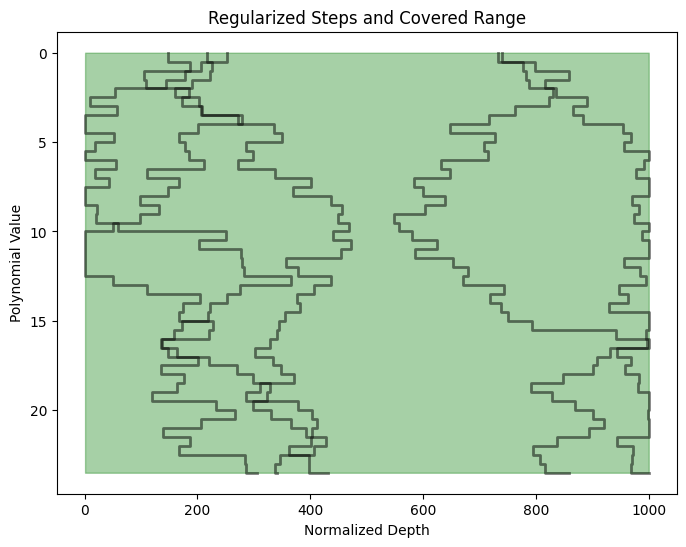

In [6]:
prior_samples = prior.sample((10000,))

# Stack the polynomials to get the minimum and maximum values at each point
prior_stack = np.stack(prior_samples)

# Compute the minimum and maximum values at each x-coordinate
step_min = np.nanmin(prior_stack, axis=0)
step_max = np.nanmax(prior_stack, axis=0)

# Plotting
plt.figure(figsize=(8, 6))

# Shaded region to indicate the range of polynomial values
plt.fill_betweenx(depths, step_min, step_max, color='forestgreen', alpha=0.4, label='Covered Range')

# Plot each polynomial
for sample in prior_samples[:5]:
    plt.plot(sample, depths, color='black', alpha = 0.5, linewidth=2, drawstyle='steps-pre')


# Labels and title
plt.xlabel('Normalized Depth')
plt.ylabel('Polynomial Value')
plt.title('Regularized Steps and Covered Range')
plt.gca().invert_yaxis()

plt.savefig('plots/step_prior.png')

# Show the plot
plt.show()

## Train or Load Posterior Network

In [5]:
train_model = False
filename_steps = "pickled_objects/steps_100k_1000_ohm_48points_new.pkl"
num_simulations = 100_000


if train_model:

    # Prepare forward model and prior for SBI Inference (forward model 5 dimensional no noise added)
    simulator, prior = prepare_for_sbi(steps_forward_model_base_noise_5, prior)
    inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)

    remaining_simulations = num_simulations
    while remaining_simulations > 0:    
        theta, x = simulate_for_sbi(simulator, prior, remaining_simulations)
        valid_simulations = torch.all(~torch.isnan(x), dim=1)
        if any(valid_simulations):
            inference.append_simulations(theta[valid_simulations], x[valid_simulations] )  # Gather the new and valid simulations in the `restriction_estimator`.
            remaining_simulations -= torch.sum(valid_simulations).item()
        else: 
            continue

    
#    (all_theta, all_x, _, ) = inference.get_simulations()
#    density_estimator = inference.append_simulations(all_theta, all_x).train()
    density_estimator = inference.train()

    posterior = inference.build_posterior(density_estimator)

    pickle_objects([inference, posterior], filename_steps)
else:
    inference, posterior = unpickle_objects(filename_steps)

## Simulation Based Calibration

In [61]:
simulator, prior = prepare_for_sbi(steps_forward_model_base_noise_5, prior)

num_sbc_runs = 1_000  # choose a number of sbc runs, should be ~100s or ideally 1000

# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = torch.empty((0, num_dim)) 
xs = torch.empty((0, num_measurements)) 
remaining_simulations = num_sbc_runs

while remaining_simulations > 0:    
    theta, x = simulate_for_sbi(simulator, prior, remaining_simulations)
    valid_simulations = torch.all(~torch.isnan(x), dim=1)
    if any(valid_simulations):
        # Concatenate valid simulations directly
        thetas = torch.cat((thetas, theta[valid_simulations]), dim=0)
        xs = torch.cat((xs, x[valid_simulations]), dim=0)
        remaining_simulations -= torch.sum(valid_simulations).item()
    else: 
        continue
        

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [62]:
# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [63]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)

In [64]:
# Kolmogorov-Smirnov Test p-values on the H_0: PDF(ranks) == PDF(uniform)
# The null hypothesis (of both distributions being equal) is rejected if the p-values fall below a significance threshold (usually < 0.05). 

print(" ****  null hypothesis (of both distributions being equal) is rejected if the p-values fall below a significance threshold (usually < 0.05) *** ")
np.set_printoptions(suppress=True)
print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)

print("\n \n **** If you see values around 0.5, the c2st classifier was unable to differentiate both ensembles ****")

# Revisiting Classifier Two-Sample Tests c2st
# If you see values around 0.5, the classifier was unable to differentiate both ensembles, i.e. ranks are very uniform. If the values are high towards 1, this matches the case where ranks is very unlike a uniform distribution.
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

print(" \n \n **** If you see values around 0.5, the c2st classifier was unable to differentiate both ensembles ****")
# Data averaged posterior (DAP) versus prior
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

 ****  null hypothesis (of both distributions being equal) is rejected if the p-values fall below a significance threshold (usually < 0.05) *** 
kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [0.7616083  0.36269188 0.1461067  0.32269013 0.10853973 0.551029
 0.02334446 0.36269224 0.09298544 0.8108967  0.32268974 0.8108968
 0.70975524 0.8108961  0.45169693 0.22129525 0.19349404 0.40574664
 0.45169738 0.04811089 0.01301206 0.32268995 0.07933962 0.19349405
 0.55102867 0.14610659 0.00289104 0.14610653 0.7097556  0.0011204
 0.01301206 0.00863791 0.32268965 0.50026447 0.28580573 0.92992187
 0.81089836 0.65664023 0.40574756 0.36269245 0.01587453]

 
 **** If you see values around 0.5, the c2st classifier was unable to differentiate both ensembles ****
c2st accuracies 
check_stats['c2st_ranks'] = [0.5945 0.5775 0.57   0.575  0.587  0.559  0.587  0.597  0.5755 0.581
 0.5905 0.5985 0.563  0.566  0.572  0.594  0.553  0.5595 0.5645 0.5525
 0.589  0.55   0.585  0.564  0.5665 0.5945 0.581  0.

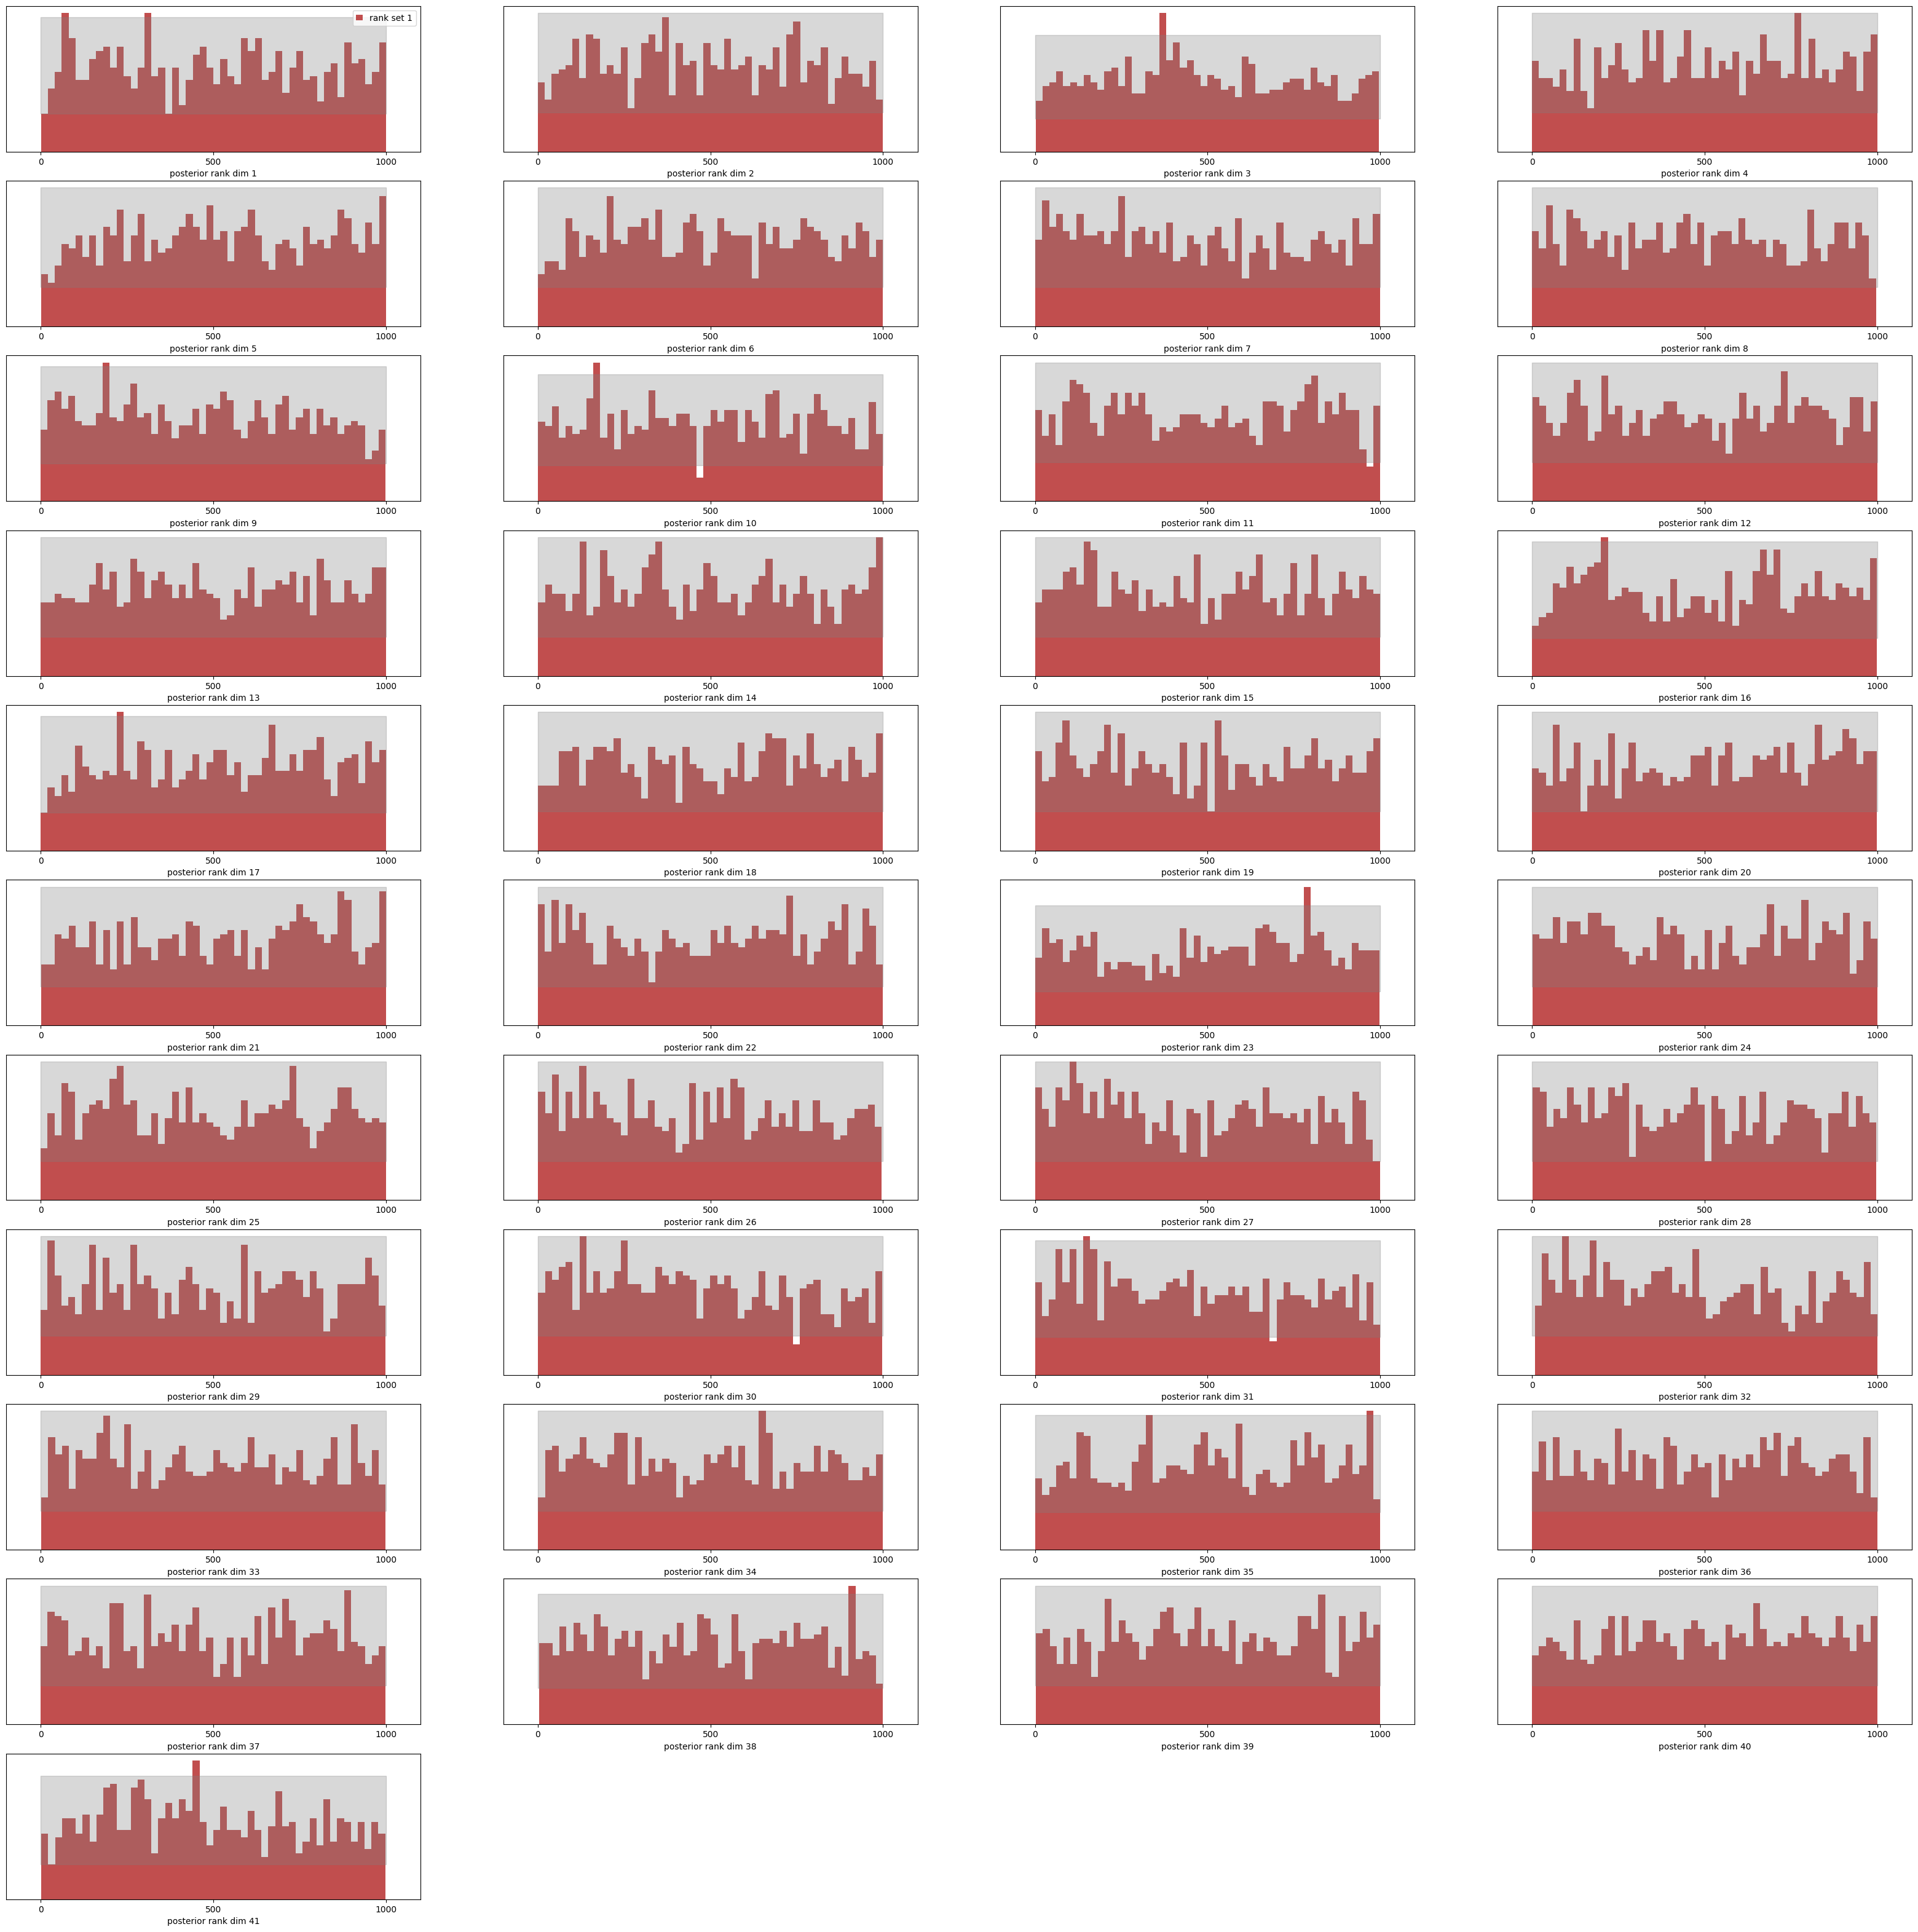

In [75]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None, # by passing None we use a heuristic for the number of bins.
    figsize=(40, 40)
)

f.savefig('plots/step_sbc_rank_plot_hist.png')

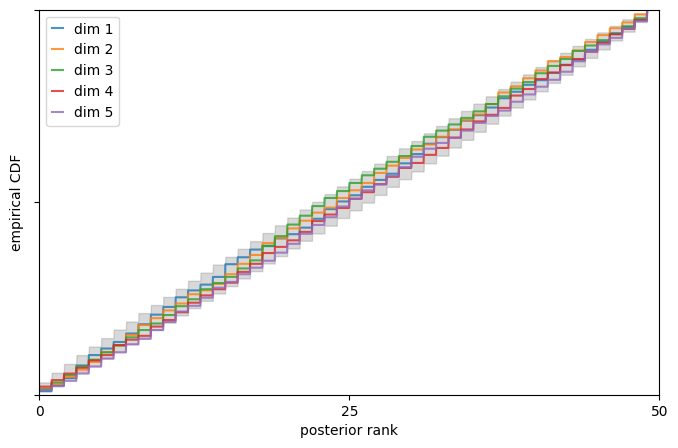

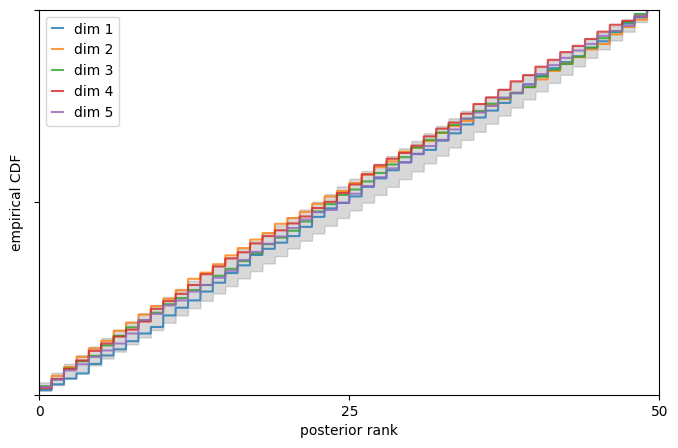

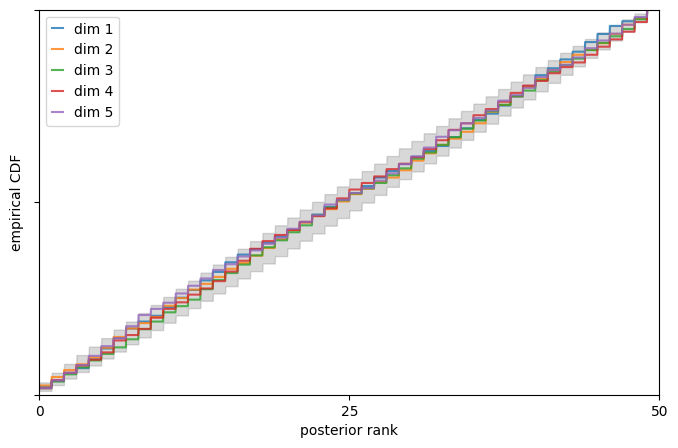

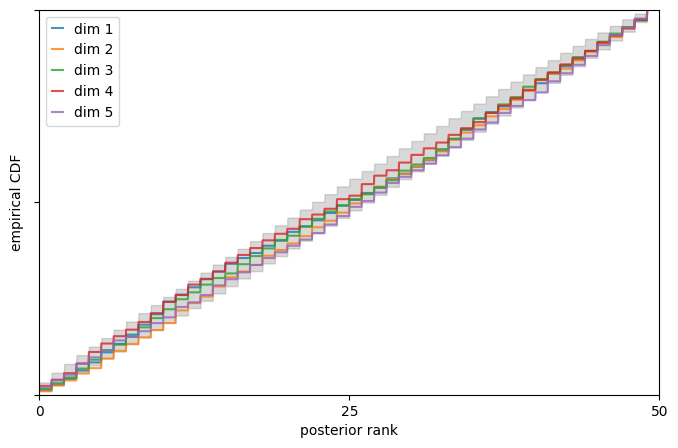

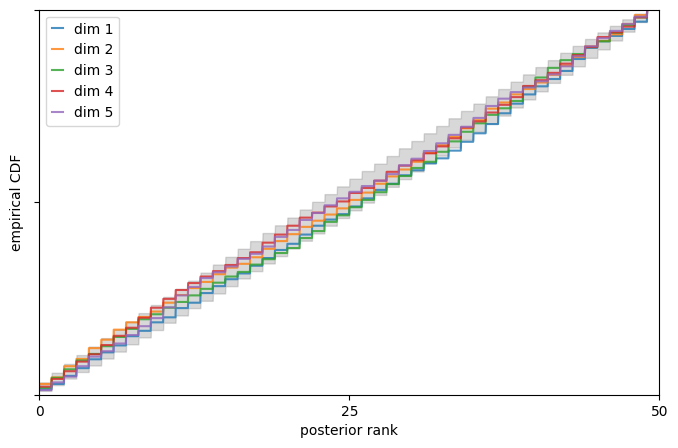

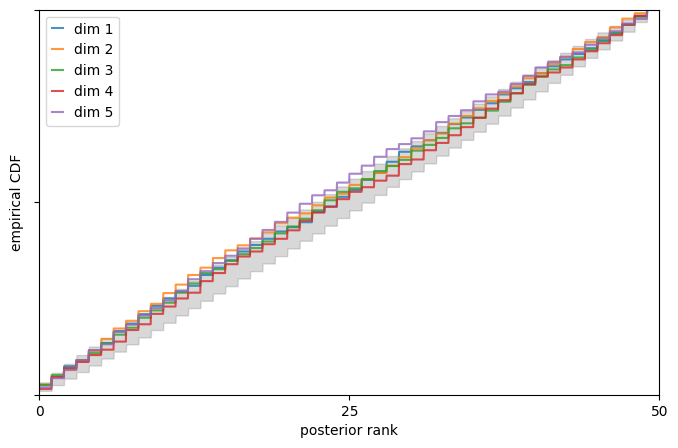

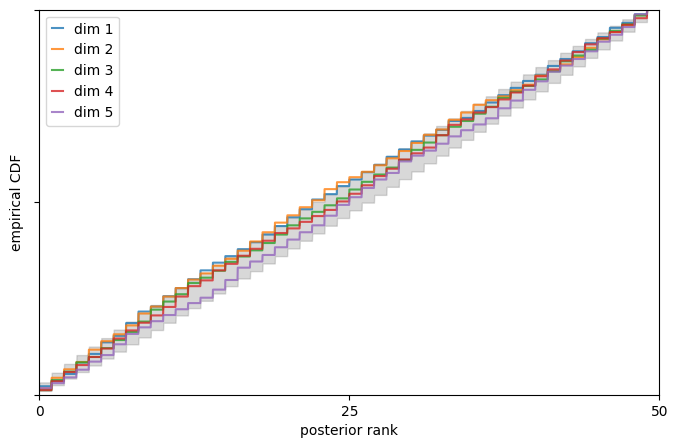

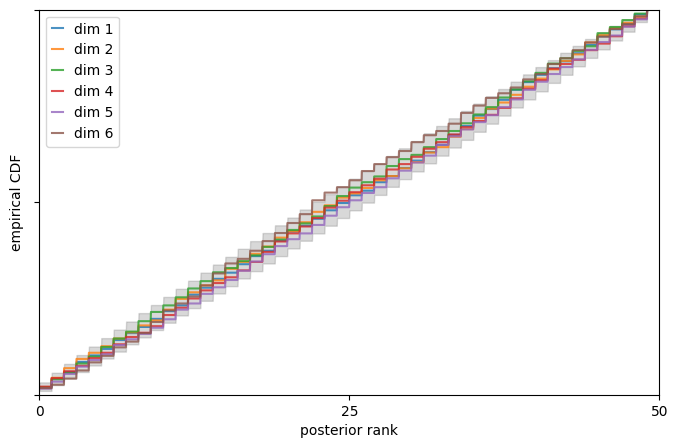

In [73]:
f5, ax5 = sbc_rank_plot(ranks[:,:5], 1_000, plot_type="cdf")
f10, ax10 = sbc_rank_plot(ranks[:,5:10], 1_000, plot_type="cdf")
f15, ax15 = sbc_rank_plot(ranks[:,10:15], 1_000, plot_type="cdf")
f20, ax20 = sbc_rank_plot(ranks[:,15:20], 1_000, plot_type="cdf")
f25, ax25 = sbc_rank_plot(ranks[:,20:25], 1_000, plot_type="cdf")
f30, ax30 = sbc_rank_plot(ranks[:,25:30], 1_000, plot_type="cdf")
f35, ax35 = sbc_rank_plot(ranks[:,30:35], 1_000, plot_type="cdf")
f40, ax40 = sbc_rank_plot(ranks[:,35:], 1_000, plot_type="cdf")




## Expected Coverage

In [7]:
simulator, prior = prepare_for_sbi(steps_forward_model_base_noise_5, prior)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

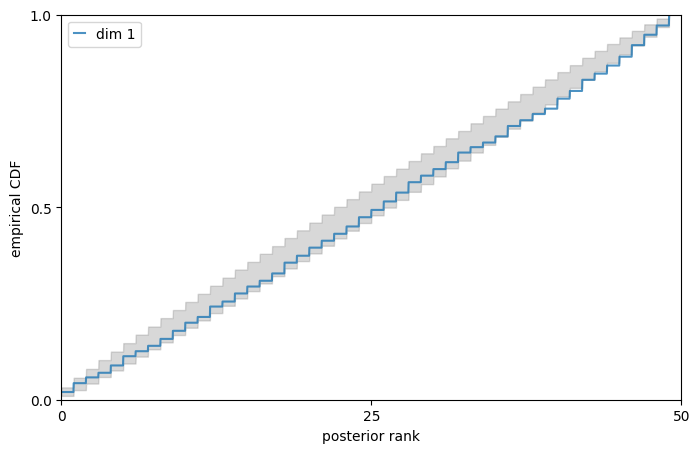

In [8]:
thetas = prior.sample((1_000,))
xs = simulator(thetas)

ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=1_000, reduce_fns=posterior.log_prob
)

(fig, ax) = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=1_000,
    plot_type="cdf",
    num_bins=None,
)

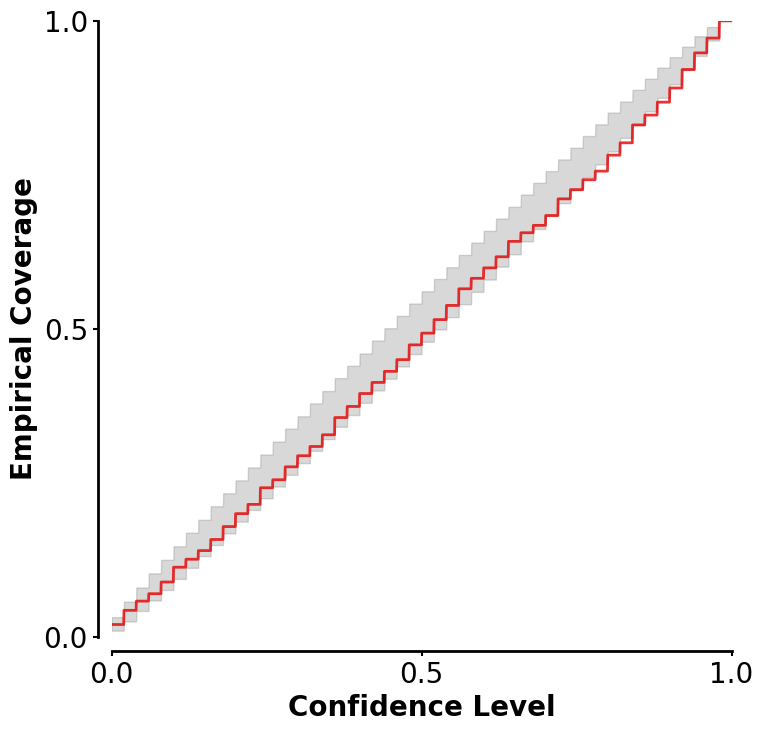

In [10]:
with mpl.rc_context(fname="plots/pltstyle.rc"):
    (fig, ax) = sbc_rank_plot(
        figsize=(8,8),
        ranks=ranks,
        num_posterior_samples=1_000,
        plot_type="cdf",
        num_bins=None,
        parameter_labels=[''],
        colors=[config.bright_red]
    )
    
    ax.set_xlabel('Confidence Level')
    ax.set_ylabel('Empirical Coverage')
    
    xticks = ax.get_xticks()
    
    # Normalize x-ticks to be in the range [0, 1]
    normalized_xticks = xticks / 50.0
    
    # Set the new x-tick labels
    ax.set_xticklabels([f'{tick:.1f}' for tick in normalized_xticks])
    
    # Hide the top and right spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    
    # Optionally, adjust the ticks
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.spines['bottom'].set_position(('outward', 10)) 
    ax.spines['left'].set_position(('outward', 10)) 
    
    
    fig.savefig('plots/calibration/sbcc/step_cdf.svg')

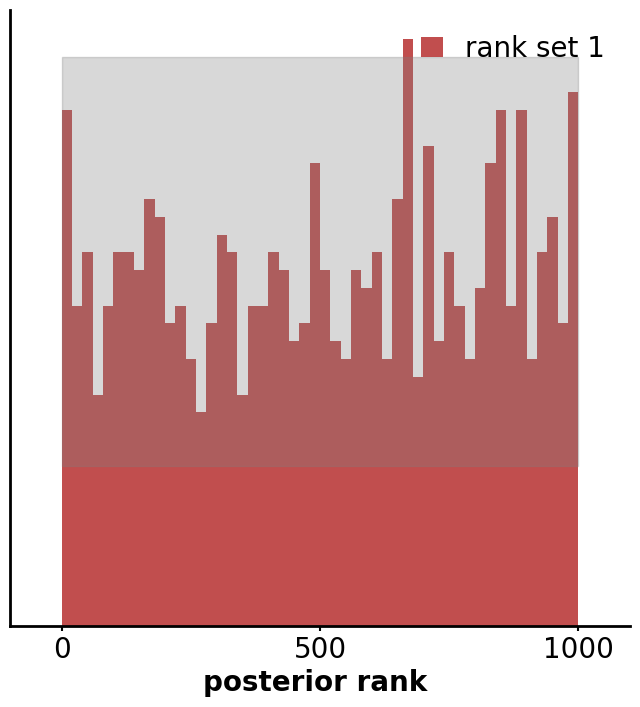

In [35]:
with mpl.rc_context(fname="plots/pltstyle.rc"):
    (fig, _) = sbc_rank_plot(
        figsize=(8,8),
        ranks=ranks,
        num_posterior_samples=1_000,
        plot_type="hist",
        num_bins=None,
        parameter_labels=['']
    )
    
    ax = fig.get_axes()    
    
    # Hide the top and right spines
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    
    # Optionally, adjust the ticks
    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].yaxis.set_ticks_position('left')
    
    
    fig.savefig('plots/calibration/sbcc/step_hist.svg')
